In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
import seaborn as sns

In [2]:
#Reading the dataset from the given csv file and removing the data entries which are null or duplicate
data = pd.read_csv('./clustering_data.csv')
data = data.dropna()
data = data.drop_duplicates()
print(data)

                   CircleName       RegionName       DivisionName  \
0       Andhra Pradesh Circle   Kurnool Region  Hindupur Division   
1       Andhra Pradesh Circle   Kurnool Region  Hindupur Division   
2       Andhra Pradesh Circle   Kurnool Region  Hindupur Division   
3       Andhra Pradesh Circle   Kurnool Region  Hindupur Division   
4       Andhra Pradesh Circle   Kurnool Region  Hindupur Division   
...                       ...              ...                ...   
157121   Uttar Pradesh Circle  Bareilly Region    Meerut Division   
157122   Uttar Pradesh Circle  Bareilly Region    Meerut Division   
157123   Uttar Pradesh Circle  Bareilly Region    Meerut Division   
157124          Kerala Circle   Calicut Region   Calicut Division   
157125          Kerala Circle   Calicut Region   Calicut Division   

                 OfficeName  Pincode OfficeType      Delivery   District  \
0            Peddakotla B.O   515631         BO      Delivery  ANANTAPUR   
1            Pinnad

/tmp/ipykernel_62641/14945182.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./clustering_data.csv')


In [3]:
#Filtering out the data entries which do not belong to home state
home_state = "GUJARAT"
data = data[(data["StateName"]==home_state)]
data["Longitude"] = pd.to_numeric(data["Longitude"])
data["Latitude"] = pd.to_numeric(data["Latitude"])
data.describe()

,Pincode,Latitude,Longitude
count,8864.000000,8864.000000,8864.000000
mean,380431.569269,22.241565,72.722750
std,12422.587352,4.889141,75.790304
min,360001.000000,15.082000,15.593400
25%,365410.000000,21.310618,71.339015
50%,384241.000000,22.310000,72.637569
75%,391145.000000,23.128424,73.160000
max,396590.000000,96.872839,7192.000000


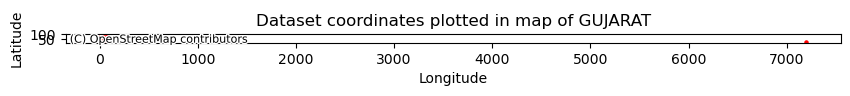

In [4]:
#Plotting the coordinates on the map before removing outliers (using shapefile)
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf.set_crs(epsg=4326, inplace=True)
gujarat_shapefile = gpd.read_file('./gujarat_district.shp')

fig,ax = plt.subplots(1,1,figsize=(10,10))
gujarat_shapefile.plot(ax=ax,color="white",edgecolor="black")
gdf.plot(ax=ax,color="red",markersize=5)

ctx.add_basemap(ax,crs=gdf.crs,source = ctx.providers.OpenStreetMap.Mapnik)
plt.title(f'Dataset coordinates plotted in map of {home_state}')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [5]:
#Removing the outliers from the dataset (values decided via trial & error)
quantileLong1 = data["Longitude"].quantile(0.0075)
quantileLong2 = data["Longitude"].quantile(0.985)
quantileLat1 = data["Latitude"].quantile(0.0765)
quantileLat2 = data["Latitude"].quantile(0.991)

data = data[(data["Longitude"]>quantileLong1) & (data["Longitude"]<quantileLong2) & (data["Latitude"]>quantileLat1) & (data["Latitude"]<quantileLat2)]

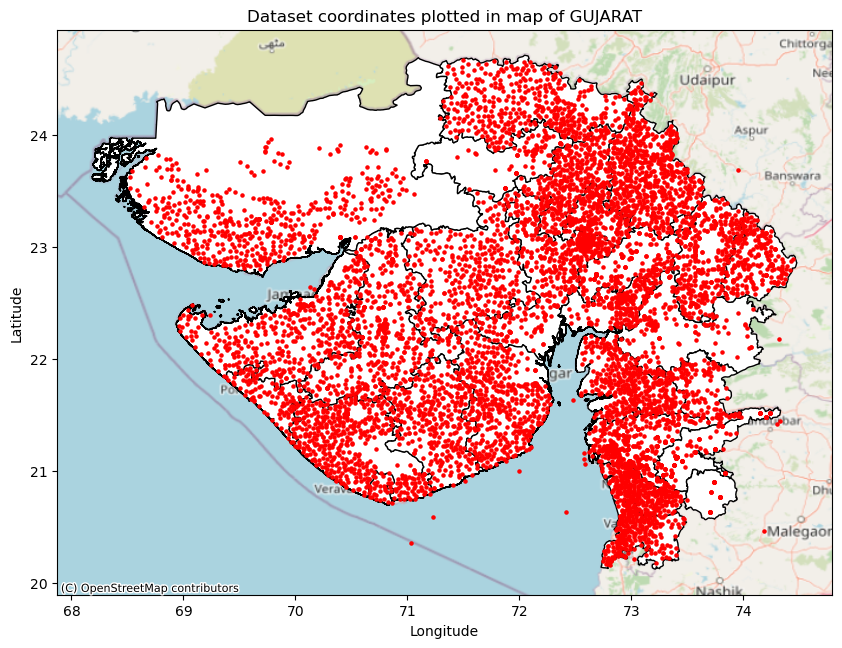

In [6]:
#Plotting the coordinates on the map after removing outliers (using shapefile)
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf.set_crs(epsg=4326, inplace=True)
gujarat_shapefile = gpd.read_file('./gujarat_district.shp')

fig,ax = plt.subplots(1,1,figsize=(10,10))
gujarat_shapefile.plot(ax=ax,color="white",edgecolor="black")
gdf.plot(ax=ax,color="red",markersize=5)

ctx.add_basemap(ax,crs=gdf.crs,source = ctx.providers.OpenStreetMap.Mapnik)
plt.title(f'Dataset coordinates plotted in map of {home_state}')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [7]:
#Keeping only the required columns in the dataframe for clustering
df = data[["Longitude","Latitude"]]

In [8]:
#Function for finding the euclidean distances of a particular data point from a given dataframe
def L2_distance(data_point,data_frame):
    return np.sqrt(np.sum((data_point-data_frame)**2,axis=1))

In [9]:
#Function for normalizing a given dataframe based on extremes of the other given dataframe
def normalize_df(data_frame,main_df):
    return (data_frame-main_df.min())/(main_df.max()-main_df.min())

In [10]:
#Function for reverting the normalization of given dataframe based on extremes of the other given dataframe
def revert_df(scaled_df,main_df):
    return scaled_df*(main_df.max()-main_df.min()) + main_df.min()

In [11]:
#Function to perform K-Means clustering on given data
def k_means(dataset,k=8,max_iterations=300):
    normalized_dataset = normalize_df(dataset,dataset)
    centroids = normalized_dataset.sample(k,replace=False)
    np.random.seed(18)
    num_iterations = 0
    prev_centroids = None

    while((prev_centroids is None or not np.array_equal(centroids, prev_centroids)) and num_iterations<max_iterations):
        clusters = [[] for i in range(k)]
        for row in normalized_dataset.values:
            distance_data = L2_distance(row,centroids)
            chosen_centroid = np.argmin(distance_data)
            clusters[chosen_centroid].append(row)

        prev_centroids = centroids
        centroids = [np.mean(cluster,axis=0) for cluster in clusters]
        for i,centroid in enumerate(centroids):
            #if no point was assigned to a given centroid, giving it the previous cluster location
            if np.isnan(centroid).any():
                centroids[i] = prev_centroids[i]
        num_iterations+=1

    #computing the WCSS (Within Cluster Sum of Squares) for the clustering process
    wcss = 0
    for i,cluster in enumerate(clusters):
        cluster = np.array(cluster)
        wcss += np.sum((cluster-centroids[i])**2)

    #returning the centroids with reverted coordinates
    centroids = pd.DataFrame(centroids,columns=normalized_dataset.columns)
    centroids = revert_df(centroids,dataset)
    
    return centroids,wcss

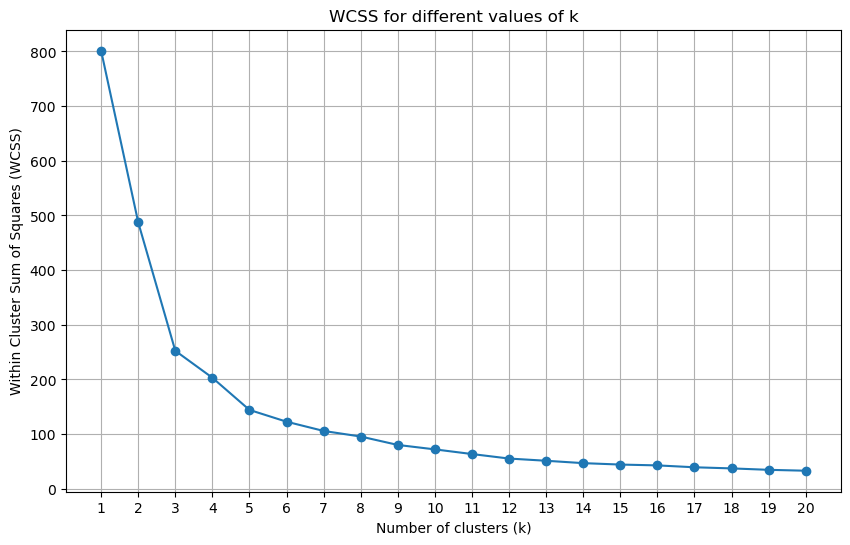

In [12]:
#Plotting the WCSS values for k=1 to k=20 in order to find the elbow point
wcss_values = []
k_values = range(1,21)

for k in k_values:
    centroids,wcss = k_means(df,k,100)
    wcss_values.append(wcss)

plt.figure(figsize=(10, 6))
plt.plot(k_values,wcss_values,marker='o')
plt.title("WCSS for different values of k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

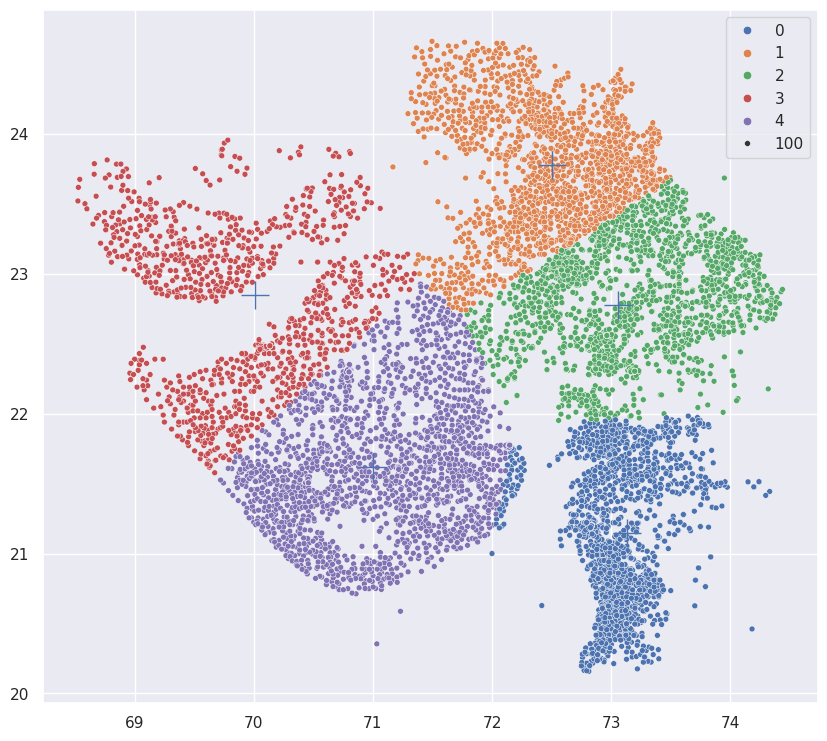

In [13]:
#Using the fact that the elbow point (point after which WCSS starts decreasing in linear fashion) occurs at k=5, that is our optimal number of clusters
centroids,wcss = k_means(df,5,100)
cluster_labels = []
for row in df.values:
    distance_data = L2_distance(row,centroids)
    cluster_labels.append(np.argmin(distance_data))

#plotting the data on a scatterplot for visualization
longitude_list = df["Longitude"].tolist()
latitude_list = df["Latitude"].tolist()
sns.set_theme(rc={'figure.figsize':(10,9)})

sns.scatterplot(x=longitude_list,
                y=latitude_list,
                hue=cluster_labels,
                palette="deep",
                size = 100
                )

plt.plot([longitude for longitude,latitude in centroids.values],[latitude for longitude,latitude in centroids.values],'+',markersize=20)
plt.show()